# MVPA NHP pipeline

this pipeline perfroms decoding analysis on pseudotrials sampled from monkey A recordings

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
from scipy.io import loadmat 
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle
from IPython.core.debugger import set_trace
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

In [2]:
# data folders. subdirectories & subject indices 
datadir = ''
fn = 'monkey_a_mvpa_pseudotrials.mat'


In [5]:

def partition_datasets(features,labels):
    """generates vector with targets
       note: task A/1 : colour relevant. task B/2: motion relevant
    """
    datasets = {}
    # train task A relevant dim (colour):
    datasets['taskA_reldim'] = {}    
    X = features[labels[:,0]==1]
    targets = labels[labels[:,0]==1,2]    
    targets = targets>3 # low vs high value for col
    
    datasets['taskA_reldim']['X'] = X
    datasets['taskA_reldim']['y'] = targets 

    
    # train task B reldim (motion):
    datasets['taskB_reldim'] = {}
    X = features[labels[:,0]==2]
    targets = labels[labels[:,0]==2,1]    
    targets = targets>3 # low vs high val for motion       
    
    datasets['taskB_reldim']['X'] = X
    datasets['taskB_reldim']['y'] = targets 


    # train task A irreldim (motion):
    datasets['taskA_irreldim'] = {}    
    X = features[labels[:,0]==1]
    targets = labels[labels[:,0]==1,1]    
    targets = targets>3 # low vs high val for motion
    
    datasets['taskA_irreldim']['X'] = X
    datasets['taskA_irreldim']['y'] = targets 
    
    # train task B irreldim (colour):
    datasets['taskB_irreldim'] = {}
    X = features[labels[:,0]==2]
    targets = labels[labels[:,0]==2,2]    
    targets = targets>3 # low vs high colour        
    
    datasets['taskB_irreldim']['X'] = X
    datasets['taskB_irreldim']['y'] = targets     


    # # task A vs task B
    # datasets['AvsB'] = {}
    # datasets['AvsB']['X'] = features
    # datasets['AvsB']['y'] = labels[:,0]

    return datasets


def gen_traintestdata_runs(swapds=False):
    """loads and partitions the data into sets for training 
       and test. labels are given for the relevant and irrelevant 
       feature dimension of each task.

    Args:
        swapds (bool): whether or not to swap training and test set (for cross-val)
    """
    data = loadmat(datadir+fn)
    
    if swapds:
        datasets_train = partition_datasets(data['X_test'],data['y_test'])
        datasets_test = partition_datasets(data['X_train'],data['y_train'])
    else:
        datasets_train = partition_datasets(data['X_train'],data['y_train'])
        datasets_test = partition_datasets(data['X_test'],data['y_test'])

    return datasets_train, datasets_test

    
def test_shuffle(X,y,clf):
    y_shuff = y[np.random.permutation(len(y))]
    yt = clf.predict(X)
    return np.mean(y_shuff == yt)

def fit_linear_svm(featuredim, C=1.0,do_pca=False):
    """trains and evaluates svm on fmri roi patterns 
       with split half cross-validation on 2880 pseudotrials (40 per condition)

    Args:
        
        featuredim (str): dictionary key for feature to fit (for example taskA_reldim)
        C (float): inverse regularisation strength (c in (0,1))
        do_pca (bool): perform pca and retain data containing 95% of variance (yes/no)

    Returns:
        results: dictionary with training and test accuracies
    """
    shuffle_accs = []
    test_accs = []
    train_accs = []
    for run_id,doswap in enumerate([False,True]):
        testaccs = []
        shuffleaccs = []
        datasets_train, datasets_test = gen_traintestdata_runs(swapds=doswap)
        # training
        sc = StandardScaler()
        clf = SVC(C=C,kernel='linear')
        X = datasets_train[featuredim]['X']
        if do_pca:
            pca = PCA(n_components=0.95,svd_solver='full')
            X = pca.fit_transform(X)
        
        X = sc.fit_transform(X)
        y = datasets_train[featuredim]['y']
        clf.fit(X, y)
        yt = clf.predict(X)
        train_accs.append(np.mean(yt == y))

        # test on all four test sets (A rel, B rel, A irrel, B irrel)
        for _, testset in datasets_test.items():
            X = testset['X']
            if do_pca:
                X = pca.transform(X)
            X = sc.transform(X)
            y = testset['y']
            yt = clf.predict(X)
            testaccs.append(np.mean(y == yt))
            # compute shuffle distribution
            sfs = Parallel(n_jobs=6,backend='loky',verbose=0)(delayed(test_shuffle)(X,y,clf) for _ in range(500))            
            shuffleaccs.append(sfs)
        shuffle_accs.append(shuffleaccs)    
        test_accs.append(testaccs)
    train_accs = np.asarray(train_accs)
    test_accs = np.asarray(test_accs)
    shuffle_accs = np.asarray(shuffle_accs)
    
    
    # average over cross-val folds:
    results = {'train_accs': np.mean(train_accs),
               'test_accs': np.mean(test_accs, 0),
               'shuff_accs':np.mean(shuffle_accs,0)
               }

    return results

    
def nonparam_test(t,t_shuff):
    # return proportion of shuffled ts that exceed empirical t
    # as approximation of p value
    return np.mean(t_shuff>t)


def plot_avg_svm_results(results,shuffresults):
    # loop over training dimensions
    mm = 1/25.4
    f,axs = plt.subplots(1,1,figsize=(55*mm,40*mm),dpi=300)
    
   
    dtes = ['same task rel','same task irrel', 'other task rel', 'other task irrel']
    idces = [(0,0),(1,1)],[(0,2),(1,3)],[(0,1),(1,0)],[(0,3),(1,2)]
    for k,idx in enumerate(idces):
        avg_res = (results[idx[0][0],idx[0][1]]+results[idx[1][0],idx[1][1]])/2
        avg_shuff = (shuffresults[idx[0][0],idx[0][1],:]+shuffresults[idx[1][0],idx[1][1],:])/2
    
        axs.bar(k,avg_res-avg_shuff.mean(),color=(0.5,0.7,0.6),edgecolor='k')
    
        axs.scatter(np.repeat(k,len(avg_shuff))+np.random.randn(len(avg_shuff))*0.01,avg_shuff-avg_shuff.mean(),color=(.9,.9,.9),alpha=0.4,zorder=3,s=10,edgecolor='k',linewidth=0.2)
        axs.errorbar(k,0,yerr=2*np.std(avg_shuff),color='k',zorder=4)
        axs.plot([-1,4],[0,0],'k--',linewidth=0.5)
        p = nonparam_test(avg_res,avg_shuff)
        print(f'tested on {dtes[k]}, \t p= {p}, \t mu={avg_res-avg_shuff.mean():.4f}')
        
        if p<0.05:
            
            if p <0.0001:
                ts = '*'*4
            elif p <0.001:
                ts = '*'*3
            elif p<0.01:
                ts = '*'*2
            elif p<0.05:
                ts = '*'
            axs.text(k,0.1,ts,{'fontsize':6,'ha':'center','fontweight':'normal'})


    axs.set_xlabel('test dimension',fontsize=6)
    axs.set_ylabel('test acc - chance (%)',fontsize=6)
    axs.set_title('Monkey A',fontsize=6)
    axs.set_yticks(np.arange(-0.2,0.21,0.1))
    axs.set_ylim=(-0.1,0.2)
    axs.set_xticks(np.arange(4))
    axs.set_xticklabels(dtes,rotation=90,fontsize=6)
    ticks = axs.get_yticks()
    axs.set_yticklabels(np.round(ticks*100,2),fontsize=6)
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
        

    plt.tight_layout()


In [ ]:

C=1.0
dims = ['taskA_reldim', 'taskB_reldim','taskA_irreldim','taskB_irreldim']
all_train_accs = np.empty((len(dims),1))
all_test_accs = np.empty((len(dims), 4))
all_shuffle_accs = np.empty((len(dims), 4, 500))

for k, d in enumerate(dims):
    print(f'processing {d} ...')
    results = fit_linear_svm(C=C,do_pca=True,featuredim=d) 
    all_train_accs[k, :] = results['train_accs']
    all_test_accs[k, :] = results['test_accs']
    all_shuffle_accs[k, :, :] = results['shuff_accs']

results = {'train_accs': all_train_accs,
           'test_accs': all_test_accs,
           'shuffle_accs':all_shuffle_accs,
           'dims': dims,           
           'regulariser': C
           }

with open('results_nhp_svm_pca.pkl', 'wb') as f:
    pickle.dump(results,f)


(array([2.000e+00, 1.300e+01, 1.590e+02, 6.960e+02, 1.825e+03, 2.749e+03,
        1.749e+03, 6.840e+02, 1.150e+02, 8.000e+00]),
 array([0.44166667, 0.45236111, 0.46305556, 0.47375   , 0.48444444,
        0.49513889, 0.50583333, 0.51652778, 0.52722222, 0.53791667,
        0.54861111]),
 <BarContainer object of 10 artists>)

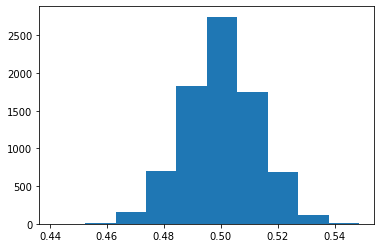

In [85]:
plt.hist(results['shuffle_accs'][:,:,:].ravel())

In [5]:

with open('results_nhp_svm_pca.pkl', 'rb') as f:
    results = pickle.load(f)
%matplotlib qt
dims_train =  ['taskA_reldim', 'taskB_reldim']
dims_test = ['taskA_reldim', 'taskB_reldim','taskA_irreldim', 'taskB_irreldim']
plot_avg_svm_results(results['test_accs'],results['shuffle_accs'])

tested on same task rel, 	 p= 0.0, 	 mu=0.0668
tested on same task irrel, 	 p= 0.996, 	 mu=-0.0235
tested on other task rel, 	 p= 1.0, 	 mu=-0.0318
tested on other task irrel, 	 p= 0.064, 	 mu=0.0116
